In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc

from regression_module import *

warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
df = pd.read_csv('data/reg_data.csv')

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
Unnamed: 0          7043 non-null int64
customerid          7043 non-null object
gender              7043 non-null object
seniorcitizen       7043 non-null int64
partner             7043 non-null object
dependents          7043 non-null object
tenure              7043 non-null int64
phoneservice        7043 non-null object
multiplelines       7043 non-null object
internetservice     7043 non-null object
onlinesecurity      7043 non-null object
onlinebackup        7043 non-null object
deviceprotection    7043 non-null object
techsupport         7043 non-null object
streamingtv         7043 non-null object
streamingmovies     7043 non-null object
contract            7043 non-null object
paperlessbilling    7043 non-null object
paymentmethod       7043 non-null object
monthlycharges      7043 non-null float64
totalcharges        7043 non-null float64
churn               7043 non-null

In [77]:
df.isnull().sum()

Unnamed: 0          0
customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [78]:
df2 = df.iloc[:,2:]

In [79]:
df2.head()

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [80]:
df2.churn.replace("Yes", 1, inplace = True)
df2.churn.replace("No", 0, inplace = True)

In [81]:
dummy_df = pd.get_dummies(df2)

In [82]:
dummy_df.head()

,seniorcitizen,tenure,monthlycharges,totalcharges,churn,gender_Female,gender_Male,partner_No,partner_Yes,dependents_No,...,streamingmovies_Yes,contract_Month-to-month,contract_One year,contract_Two year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,0,1,29.85,29.85,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,0,1,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


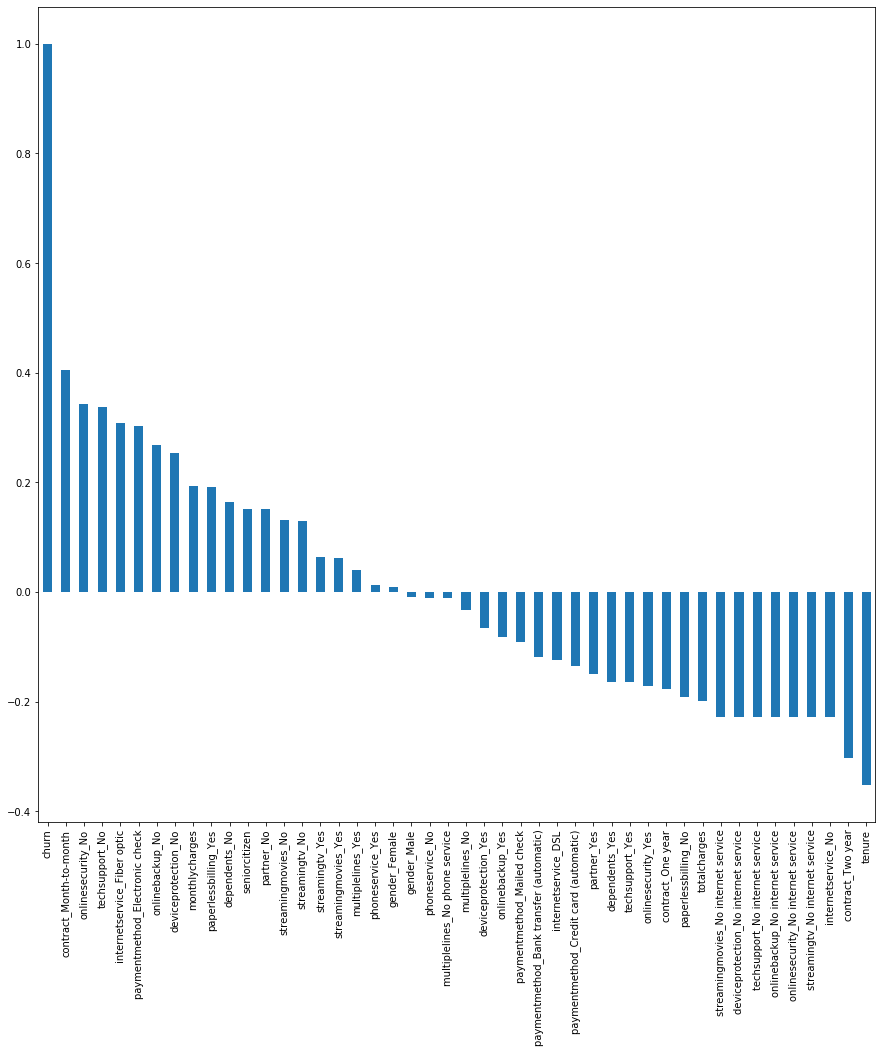

In [83]:
dummy_df.corr()['churn'].sort_values(ascending = False).plot('bar', figsize = (15, 15));

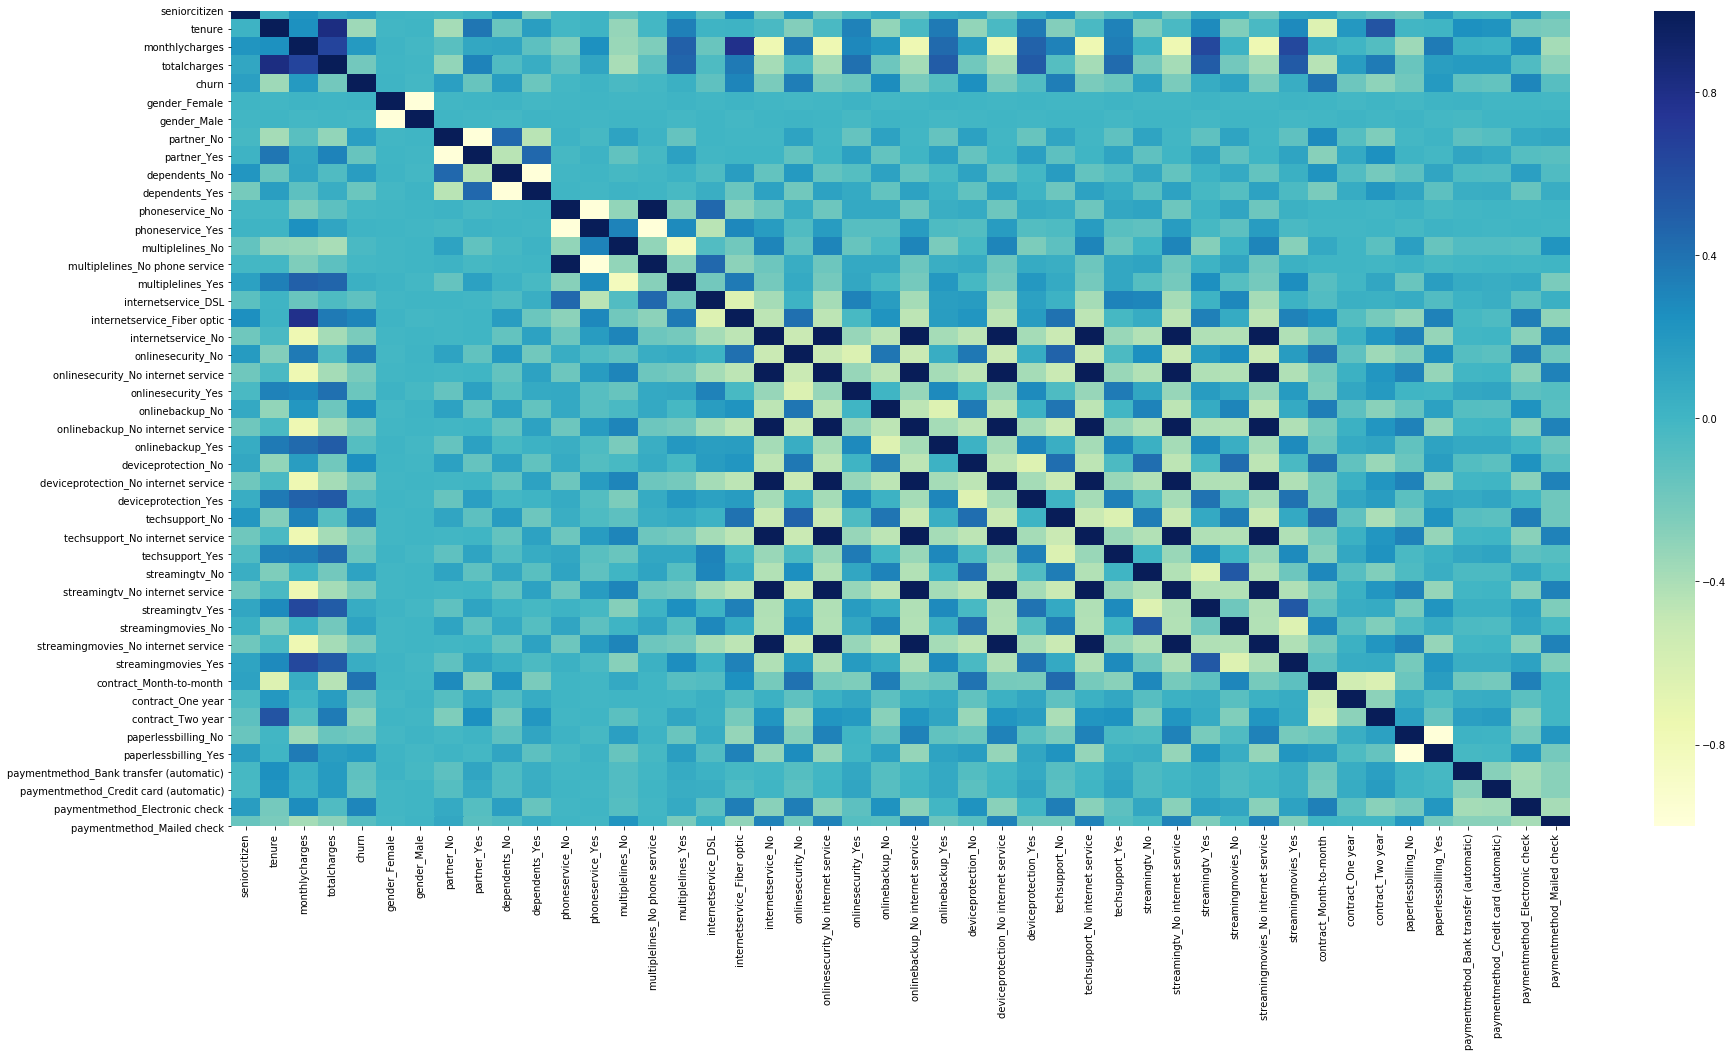

In [84]:
plt.figure(figsize = (30, 15))
x = sns.heatmap(dummy_df.corr(), cmap = 'YlGnBu')

## From our heatmap and correlation barplot, we see that monthly contract, and a lack of online security or techsupport have the strongest *positive* correlation with churn. 2-Year Contracts and not having internet service are the most negatively correlated with churn. 

# Logistic Regression

In [85]:
# Establish our target feature, churn, as our y feature
y = dummy_df.churn.values
# Drop our target feature from our features dataframe
X = dummy_df.drop('churn', axis = 1)
# Save dataframe column titles to list for reassigning after min max scale 
cols = X.columns

In [86]:
# Instantiate min-max scaling object
mm = MinMaxScaler()
# Fit and transform our feature dataframe
X = pd.DataFrame(mm.fit_transform(X))
# Reassign column names so new dataframe has corresponding names
X.columns = cols
X

,seniorcitizen,tenure,monthlycharges,totalcharges,gender_Female,gender_Male,partner_No,partner_Yes,dependents_No,dependents_Yes,...,streamingmovies_Yes,contract_Month-to-month,contract_One year,contract_Two year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,0.0,0.013889,0.115423,0.003437,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.472222,0.385075,0.217564,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.027778,0.354229,0.012453,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.625000,0.239303,0.211951,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.027778,0.521891,0.017462,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0.0,0.333333,0.662189,0.229194,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7039,0.0,1.000000,0.845274,0.847792,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
7040,0.0,0.152778,0.112935,0.039892,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7041,1.0,0.055556,0.558706,0.035303,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [87]:
# Perform train test split from our target feature series and the predicting feature dataframe (set test size to 25% of data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 33)

In [88]:
logreg = LogisticRegression(fit_intercept = False, C = 1e12, solver = 'liblinear')
logreg.fit(X_train, y_train)

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [89]:
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

## How many times was the classifier correct on the training set?

In [90]:
residuals = np.abs(y_train - y_hat_train)
print(pd.Series(residuals).value_counts())
print('----------------------------------')
print(pd.Series(residuals).value_counts(normalize = True))

0    4270
1    1012
dtype: int64
----------------------------------
0    0.808406
1    0.191594
dtype: float64


## **Train Set Results:**
* 4270 Correct (1012 Incorrect)
* 80.8 % Accuracy

## How many times was the classifier correct on the test set?


In [91]:
residuals = np.abs(y_test - y_hat_test)
print(pd.Series(residuals).value_counts())
print('---------------------------------')
print(pd.Series(residuals).value_counts(normalize = True))

0    1409
1     352
dtype: int64
---------------------------------
0    0.800114
1    0.199886
dtype: float64


## **Test Set Results:**
* 1409 Correct (352 Incorrect)
* 80.01% Accuracy

## Confusion Matrix

In [92]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion MatrixL: \n', cnf_matrix)

Confusion MatrixL: 
 [[1153  128]
 [ 224  256]]


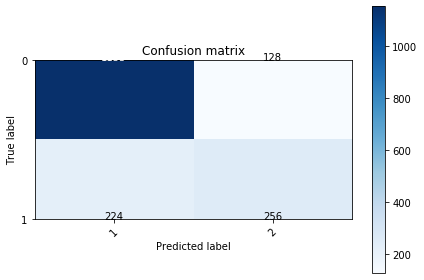

In [114]:
plot_confusion_matrix(cnf_matrix, cmap = 'Blues')

In [128]:
print_metrics(y_train, y_hat_train, y_test, y_hat_test)

Training Precision:  0.6869565217391305
Testing Precision:  0.6326662362814719


Training Recall:  0.6475409836065574
Testing Recall:  0.5609616485403549


Training Accuracy:  0.8127962085308057
Testing Accuracy:  0.7982177918743393


Training F1-Score:  0.6666666666666667
Testing F1-Score:  0.5946601941747574


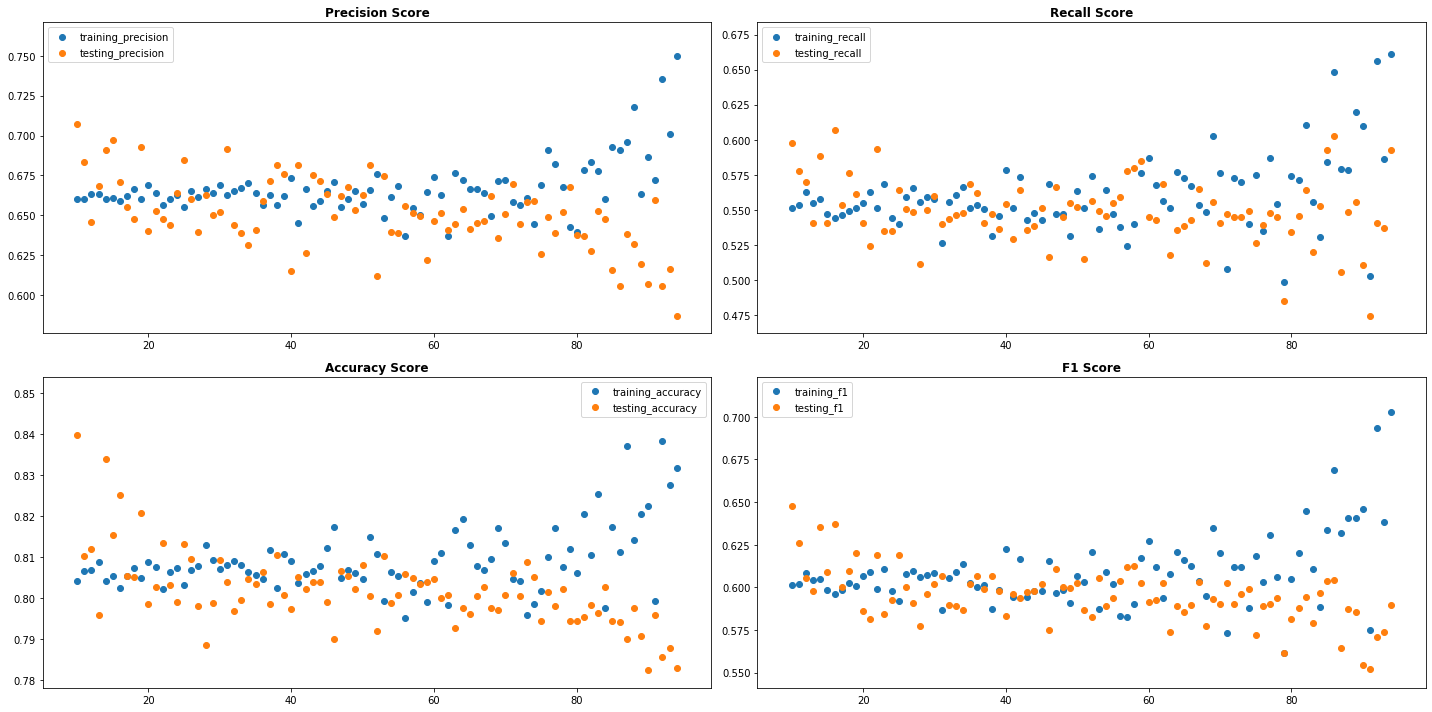

In [139]:
print_metric_comparisons(X, y)

Training AUC: 0.8646994535519124
Test AUC: 0.835441564752895


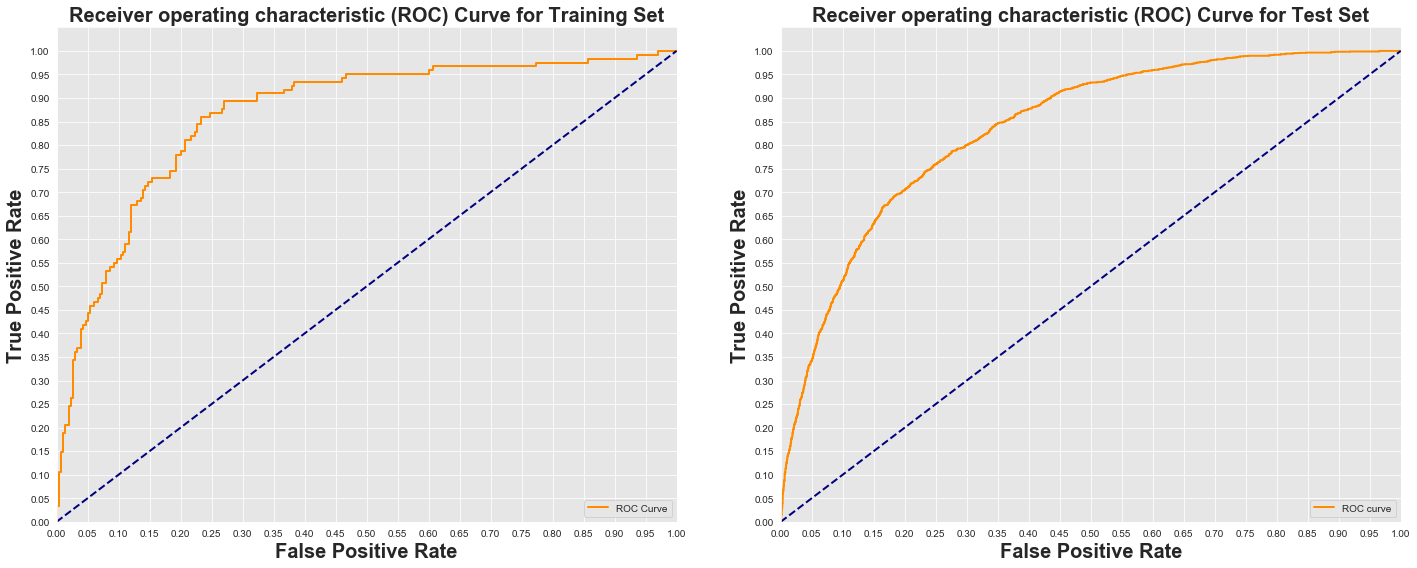

In [157]:
plot_auc(logreg, X_train, X_test, y_train, y_test)